In [ ]:
pip install deepface

In [1]:
import os
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt
from deepface import DeepFace
import cv2
import pandas as pd
import requests
from urllib.parse import urlparse
from collections import Counter
import matplotlib.gridspec as gridspec

In [98]:
base='d://Develop/Model Desiging and Testing/Face Recognition/'
img1=base+"CelebA_HQ_facial_identity_dataset/train/67/28352.jpg"
link='https://hips.hearstapps.com/digitalspyuk.cdnds.net/12/48/cult_merlin_s05_e09_1.jpg?crop=0.667xw:1xh;center,top&resize=2048:*'
img2=base+"CelebA_HQ_facial_identity_dataset/train/2193/26072.jpg"
db=base+"CelebA_HQ_facial_identity_dataset/train"
metrics = ["cosine", "euclidean", "euclidean_l2"]
backends = [
  'opencv', 
  'ssd', 
  'dlib', 
  'mtcnn', 
  'retinaface', 
  'mediapipe',
  'yolov8',
  'yunet',
  'fastmtcnn',
]
models = [
  "VGG-Face", 
  "Facenet", 
  "Facenet512", 
  "OpenFace", 
  "DeepFace", 
  "DeepID", 
  "ArcFace", 
  "Dlib", 
  "SFace",
]

In [3]:
def download_image(image_url):
    
# Send a GET request to the URL
    response = requests.get(image_url)

# Check if the request was successful (status code 200)
    if response.status_code == 200:
    # Create a folder if it doesn't exist
        folder_name = 'downloaded_images'
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

    # Parse the URL to get the filename
        parsed_url = urlparse(image_url)
        file_name = os.path.basename(parsed_url.path)

    # Define the file path to save the image
        file_path = os.path.join(folder_name, file_name)

    # Save the image to the specified file path
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"Image downloaded and saved as '{file_path}'")
        return file_path
    else:
        return ("Failed to download the image")
def remove_file(file_path):
    # Check if the file exists before attempting to remove it
    if os.path.exists(file_path):
        # Remove the file
        os.remove(file_path)
        print(f"File '{file_path}' removed successfully.")
    else:
        print(f"The file '{file_path}' does not exist.")
def is_image_url_or_path(string,base):
    if string.startswith("http://") or string.startswith("https://"):
        img_path=base+download_image(link)
        return img_path
    else:
        return string

In [96]:
def display_faces(df,img_path,most_matching_face_filename,coordinates):
    #  identify_path_list=dfs[i]['identity'].tolist()
    identify_path_list=df['identity'].tolist()
    most_matching_path=[]
    x1,y1,x2,y2=coordinates
    for path in identify_path_list:
        if os.path.basename(os.path.dirname(path))==most_matching_face_filename:
            most_matching_path.append(path)

    fig = plt.figure(tight_layout=True)
    
    length=len(most_matching_path)
    rows = 5
    gs = gridspec.GridSpec(rows, 2)


    ax = fig.add_subplot(gs[0, :])
    # f.add_subplot(length, 1, 1)
    img=image.load_img(img_path)
    img_array = image.img_to_array(img)
    crop_face_detect = img_array[y1:y2, x1:x2, :]
    cropped_img = image.array_to_img(crop_face_detect)
    
    plt.imshow(cropped_img)
    plt.title(os.path.basename(os.path.dirname(img_path)))
    # # plt.imshow(cropped_img)
    # plt.title(most_matching_face_filename)
    # plt.xticks([])
    # plt.yticks([])
    col=0
    row=1
    min_val=min(len(most_matching_path),5)
    for i,path in enumerate(most_matching_path[:min_val]) :
        if col>1:
            col=0
            row+=1
        # if col<=2:
        subplt = fig.add_subplot(gs[row, col])
        img = image.load_img(path)
        
        plt.imshow(img)
        plt.title(most_matching_face_filename)
        
        col+=1
        # plt.imshow(img)
        # plt.title(os.path.basename(os.path.dirname(path)))
        # plt.xticks([])
        # plt.yticks([])
    
    plt.show()
def find_faces(image_path,face_db_path,distance_matrics,detector_backend,model_name):
    dfs=DeepFace.find(img_path=image_path,db_path=face_db_path, distance_metric = distance_matrics[2],detector_backend=detector_backend[3] ,model_name=model_name[2])
    
    all_recognitions=[]
    all_no_recognitions=[]
    source_persons=[]
    list_recognitions=[]

    for i in range(len(dfs)):
        identify_path_list=dfs[i]['identity'].tolist()
        no_recognitions=len(identify_path_list)
        all_no_recognitions.append(no_recognitions)
        recognize_person=[]

        for path in identify_path_list:
            parent_folder = os.path.basename(os.path.dirname(path))
            recognize_person.append(parent_folder)
        all_recognitions.append(recognize_person)

        for j in range(no_recognitions):
            x1=int(dfs[i]['source_x'].tolist()[j])
            y1=int(dfs[i]['source_y'].tolist()[j])
            x2=x1+int(dfs[i]['source_w'].tolist()[j])
            y2=y1+int(dfs[i]['source_h'].tolist()[j])
            source_persons.append([x1,y1,x2,y2])
            
    # Removing duplicates from source_persons
    source_persons_unique =  pd.DataFrame(source_persons, columns=['x1', 'y1', 'x2', 'y2']).drop_duplicates()
    
    for i in range(len(all_recognitions)):
        recg=all_recognitions[i]
        list_re=Counter(dict(Counter(recg))).most_common()
        list_recognitions.append({'person_index': i ,
                                  'detect_person_coordinates':source_persons_unique.to_numpy()[i] ,
                                  'num_recognition': all_no_recognitions[i],
                                  'recognitions_list': list_re})
        display_faces(dfs[i],image_path,list_re[0][0],source_persons_unique.to_numpy()[i])
    return list_recognitions

24-02-19 16:17:04 - There are 4384 representations found in representations_facenet512.pkl
1/1 [==============================] - 0s 34ms/step
24-02-19 16:17:07 - find function lasts 3.9224977493286133 seconds
67
67
67
67
67


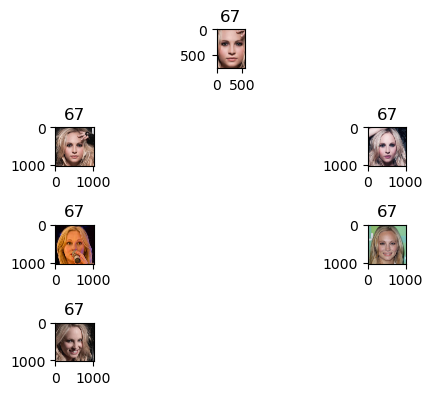

In [99]:
path=is_image_url_or_path(img1,base)
predictions=find_faces(image_path=path,face_db_path=db,distance_matrics=metrics,detector_backend=backends,model_name=models)
# most_matching_person_name=predictions[0]['recognitions_list'][0][0]
# number_of_matching_faces=predictions[0]['recognitions_list'][0][1]
# print(most_matching_person_name,"====>",number_of_matching_faces)

In [10]:
detect=DeepFace.detectFace(img1)

plt.imshow(detect)
result= DeepFace.verify(img1_path=img1,img2_path=img2, model_name='Facenet512',distance_metric = metrics[2],detector_backend=backends[3] )
result

24-02-16 09:14:53 - ⚠️ Function detectFace is deprecated. Use extract_faces instead.


In [75]:
name_counts = Counter(nameList)
list=dict(name_counts)
# Convert the dictionary to a Counter object
name_counts = Counter(list)

# Sort the items by count in descending order
sorted_counts = name_counts.most_common()
sorted_counts[0][0]

'458'

In [60]:
import shutil
import os

# Source directory containing the images
directory = "d:/Develop/Model Desiging and Testing/Face Recognition/ckeck"


# List of image paths
identify_path = dfs[0]['identity'].tolist()

# Iterate over each image path and copy it to the destination directory
for i,image_path in enumerate(identify_path):
    if image_distance[i]<20:
        # Extract the filename from the image path
        image_filename = os.path.basename(image_path)
        print(image_filename)
        # Construct the source and destination paths
        copy_path = directory+"/"+image_filename
        print(copy_path)

        # Copy the image file to the destination directory
        shutil.copyfile(image_path, copy_path)

print("Images copied successfully.")


Abdullah_0004.jpg
d:/Develop/Model Desiging and Testing/Face Recognition/ckeck/Abdullah_0004.jpg
Abdullah_0001.jpg
d:/Develop/Model Desiging and Testing/Face Recognition/ckeck/Abdullah_0001.jpg
Abdullah_0003.jpg
d:/Develop/Model Desiging and Testing/Face Recognition/ckeck/Abdullah_0003.jpg
Images copied successfully.


In [ ]:
import tarfile

# Replace "lfw-funneled.tgz" with the name of your .tgz file
file_path = "lfw-funneled.tgz"

# Extract the contents of the .tgz file
with tarfile.open(file_path, "r:gz") as tar:
    tar.extractall()